# Исследование сервиса аренды самокатов 

**Цели:**

- Найти факторы и проверить гипотезы, которые помогут бизнесу увеличить прибыль и возможность роста;
- Определить какие категории пользователей являются более прибыльными, какие проводят в приложении больше времени.

**План работы**

* Выгрузить данные из csv-файлов и изучить информацию о датафреймах;
* Провести предобработку данных:
    * Проверить есть ли несоответствие типов данных столбцов и если нужно привести к правильным;
    * Добавить новый столбец с номером месяца;
    * Найти и изучить пропуски в данных, если возможно - обработать их;
    * Проверить наличие явных и неявных дубликатов, устранить их, если имеются;
* Провести исследовательский анализ:
    * Проанализировать данные датафреймов с помощью визуализации:
        * частота встречаемости городов;
        * соотношение пользователей с подпиской и без подписки;
        * возраст пользователей;
        * расстояние, которое пользователь преодолел за одну поездку;
        * продолжительность поездок;
* Провести объединение данных:
    * Объединить данные о пользователях, поездках и подписках в один датафрейм;
    * Из объединенного датафрейма создать два датафрейма:
        * с данными о пользователях без подписки;
        * с данными о пользователях с подпиской;
    * Для пользователей обеих категорий визуализировать информацию о расстоянии и времени поездок;
* Произвести подсчет выручки:
    * Из объединенного датафрейма создать новый датафрейм с агрегированными данными:
        * найти суммарное расстояние;
        * найти количество поездок для каждого пользователя за каждый месяц;
        * найти суммарное время для каждого пользователя за каждый месяц;
    * В новый датафрейм добавить столбец с помесячной выручкой, которую принес каждый пользователь;
* Произвести проверку гипотез:
    * Понять, тратят ли пользователи с подпиской больше времени на поездки?;
    * Проверить, не привешает ли среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, расстояние одной поездки, оптимальной с точки зрения износа самоката?;
    * Проверить, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?;
    * Проверить, снизилось ли количество обращений в тех. поддержку приложения, после обновления сервера? Сравнить количесвто обращений до и после обновления;
* Распределения: 
    * Подобрать параметры распределения, построить график распределения и выяснить, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выпонить план была примерно 5%;
    * С помощью аппроксимации построить график распределения и оценить вероятность того, что уведомление откроют не более 399.5 тысяч пользователей;   
* Добавить выводы по проделанной работе.

In [1]:
#Импортируем необходимые библиотеки
import pandas as pd
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from math import sqrt
from scipy.stats import norm
from scipy.stats import binom

#### Шаг 1. Загрузка данных

Выгрузим данные из файлов и выведем основную информацию на экран.

In [2]:
users_go = pd.read_csv('dataset/users_go.csv')
users_go.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [3]:
users_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [4]:
#Сразу при выгрузке меняем тип даты
rides_go = pd.read_csv('dataset/rides_go.csv',  parse_dates=['date'])
rides_go.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [5]:
rides_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


In [6]:
subscriptions_go = pd.read_csv('dataset/subscriptions_go.csv')
subscriptions_go.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [7]:
subscriptions_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 196.0+ bytes


При первичном изучении датафрейма можно заметить:
* Названия столбцов записаны корректно и соответствуют стилю 'snake case', поэтому менять названия столбцов в будущем не нужно;
* В столбцах одинаковое количество ненулевых элементов, значит, пропусков нет, но на следующем этапе более подробно проверим это.

#### Шаг 2. Предобработка данных

На основе столбца с датой создадим отдельный столбец с месяцем.

In [8]:
rides_go['month'] = rides_go['date'].dt.month

#Выведем первые строки таблицы, чтобы посмотреть: добавился ли новый столбец
rides_go.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


Новый столбец успешно добавился в таблицу. Цифра номера месяца в новом столбце совпадает с номером месяца в соответсвующей строке столбца `date`.

Проверим за какой период у нас собраны данные в таблице.

In [9]:
print('В таблицах представлены данные за:', rides_go['date'].dt.year.unique(), 'год.')

В таблицах представлены данные за: [2021] год.


В текущих таблицах представлены данные за 2021 год.

Ниже проверим есть ли в датафреймах пропуски и дубликаты.


In [10]:
users_go.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [11]:
rides_go.isna().sum()

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

In [12]:
subscriptions_go.isna().sum()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

В данных таблицах пропущенных значений нет. Посмотрим, как обстоят дела с дубликатами. 

Сначала проверим неявные дубликаты. Они могут возникать не во всех столбцах. Например, в таблице `subscriptions_go` всего две строки и 4 столбца, и при выводе таблицы, видим, что дубликатов в ней нет. 

Что касается таблицы `users_go`, то в ней неявные дубликаты могут быть в столбце `city` или `name`. Ниже проверим уникальные значения данных столбцов.

In [13]:
users_go['city'].unique()

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

Неявные дебликаты отсутствуют в столбце `city`.

In [14]:
print('Количество уникальных значений столбца "name":', len(users_go['name'].unique()))

Количество уникальных значений столбца "name": 194


In [15]:
users_go['name'].unique()

array(['Кира', 'Станислав', 'Алексей', 'Константин', 'Адель', 'Регина',
       'Игорь', 'Юрий', 'Ян', 'Валерий', 'Агата', 'Марк', 'Ева',
       'Антонина', 'Валерия', 'Амалия', 'Даниил', 'Аделина', 'Святогор',
       'Борис', 'Вероника', 'Ростислав', 'Назар', 'Эдуард', 'Василий',
       'Денис', 'Тамара', 'Николай', 'Эвелина', 'Федор', 'Руслан', 'Иван',
       'Любовь', 'Ярослава', 'Майя', 'Ильдар', 'Данила', 'Нина',
       'Стефания', 'Ясмина', 'Дмитрий', 'Александр', 'Одиссей', 'Арсений',
       'Алла', 'Таисия', 'Максим', 'Юлиана', 'Павел', 'Карина', 'Алиса',
       'Лидия', 'Рамиль', 'Родион', 'Ника', 'Оксана', 'Анастасия',
       'Маргарита', 'Вера', 'Тимур', 'Никита', 'Лев', 'Влад', 'Артур',
       'Анна', 'Ольга', 'Вячеслав', 'Ксения', 'Виталина', 'Владислав',
       'Тамерлан', 'Амина', 'Вадим', 'Олеся', 'Зарина', 'Егор', 'Гордей',
       'Лилия', 'Святослав', 'Роберт', 'Амир', 'Влада', 'Богдан',
       'Полина', 'Марат', 'Елисей', 'Макар', 'Алина', 'Глеб', 'Андрей',
       'Ал

В таблице в основном записаны полные имена, но есть некоторые значения сокращенного типа, заменим их на полную версию.

In [16]:
users_go['name'] = users_go['name'].str.replace('Наташа', 'Наталья')
users_go['name'] = users_go['name'].str.replace('Софья', 'София')

In [17]:
print('Количество уникальных значений столбца "name":', len(users_go['name'].unique()))

Количество уникальных значений столбца "name": 192


Количество уникальных значений столбца сократилось как раз на два значений.

Теперь проверим полные дубликаты:

In [18]:
subscriptions_go.duplicated().sum()

0

In [19]:
rides_go.duplicated().sum()

0

In [20]:
users_go.duplicated().sum()

31

В таблице `users_go` имеются полные дубликаты, обработаем их.

In [21]:
users_go = users_go.drop_duplicates()

In [22]:
#Проверим удалились ли полные дубликаты
users_go.duplicated().sum()

0

**Вывод:** 

В текущем разделе была проведена предобработка данных:
* Были проверены и заменены на соответствующие типы данных столбцов в датафреймах;
* Был добавлен новый столбец с указанием номера месяца, в котором пользователь совершал поездку;
* Было выяснено, что данные представлены за 2021 год;
* Была произведена проверка и устранение явных и неявных дубликатов.

#### Шаг 3. Исследовательский анализ данных

Исследуем и визуализируем общую информацию о пользователях и поездках ниже.

In [23]:
users_go['city'].count()

1534

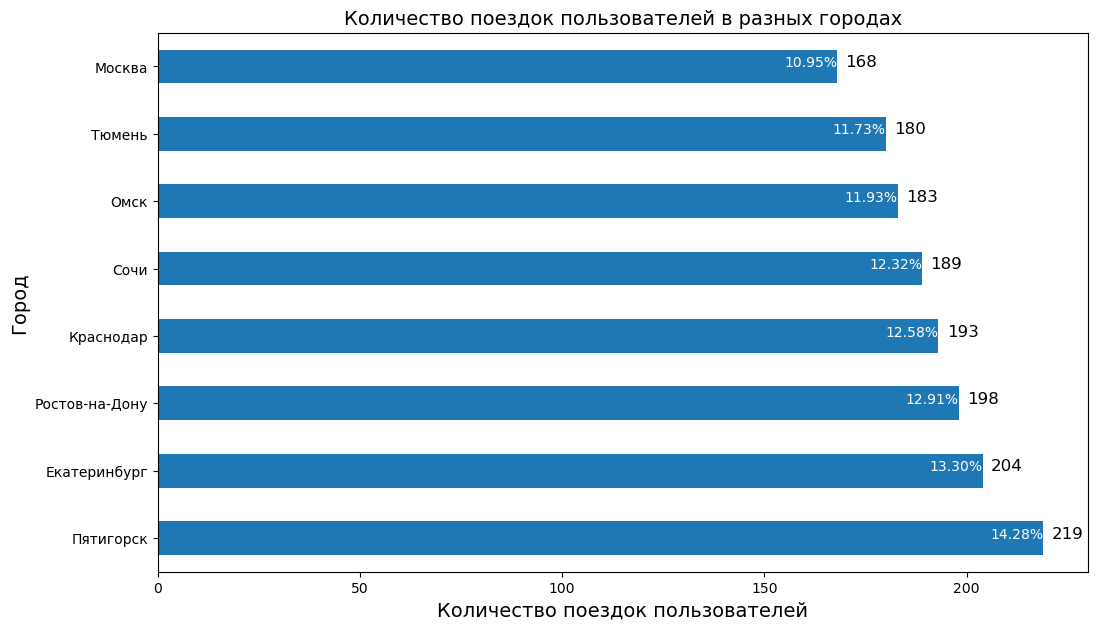

In [24]:
#Построим график, показывающий частоту встречаемости городов
users_go['city'].value_counts(ascending=False).plot(kind='barh', figsize=(12, 7))
total = users_go['city'].count()
for i, v in enumerate(users_go['city'].value_counts()):
    plt.text(v + 6, i, str(round(v, 2)), ha = 'center', size = 12)
    plt.text(v, i, str("{:.2%}".format(v/total)), ha='right', color="w", size=10)
plt.title('Количество поездок пользователей в разных городах', fontsize=14)
plt.ylabel('Город', fontsize=14)
plt.xlabel('Количество поездок пользователей', fontsize=14)
plt.show()

На столбчатой диаграмме видно какие города чаще встречаются, а какие реже. Самый часто встречающийся город - Пятигорск, а самый реже встречающийся - Москва. 

Найдем насколько сильно отличаются в цифрах количество поездок в Москве и Пятигорске. 

In [25]:
diff_city_rides = (users_go['city']=='Пятигорск').sum() / (users_go['city']=='Москва').sum() * 100 - 100

print('Количество поездок в Пятигорске на',
      round(diff_city_rides, 2), '% больше, чем поездок в Москве.')

Количество поездок в Пятигорске на 30.36 % больше, чем поездок в Москве.


Количество поездок в Пятигорске на 30% больше, чем количество поездок в Москве. Это очень большая разница учитывая население этих городов. Возможно, это также связано с расположением городов и длительностью сезона проката самокатов. Также в Москве может быть меньший процент за счет того, что там больше альтернативных транспортов.

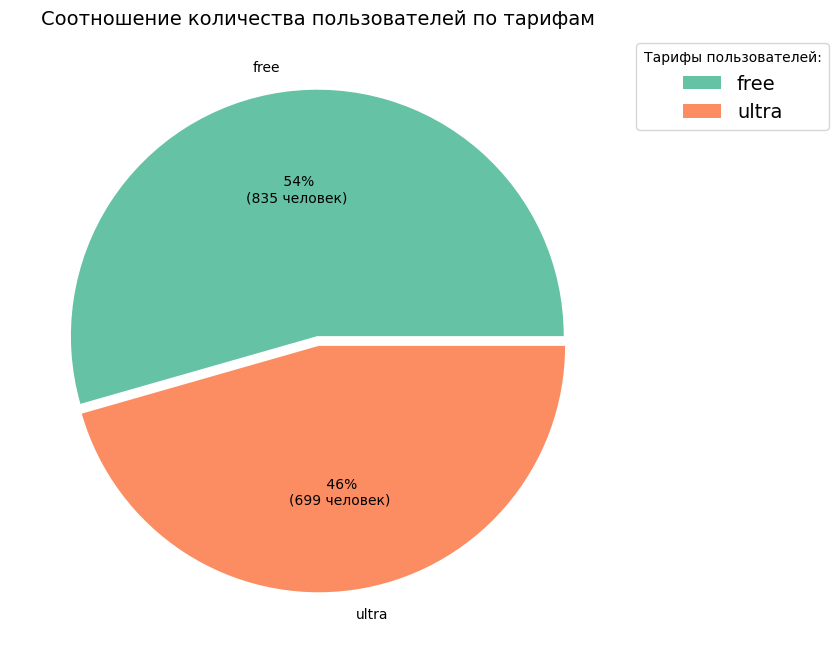

In [26]:
#Построим график, показывающий соотношение пользователей с подпиской и без подписки
def labels_for_pie(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"{pct: 1.0f}%\n({absolute:d} человек)"

users_go['subscription_type'].value_counts(ascending=False).plot(kind='pie',
                                                                 figsize=(8, 8),
                                                                 colors=sns.color_palette('Set2'),
                                                                 explode=[0.02, 0.02],
                                                                 fontsize=10,
                                                                 autopct=lambda pct: labels_for_pie(pct,
                                                                 users_go['subscription_type'].value_counts()))
plt.title('Соотношение количества пользователей по тарифам', fontsize=14)
plt.legend(title='Тарифы пользователей:',
          fontsize=14,
          bbox_to_anchor=(1, 0, 0, 1))
plt.axis('off')
plt.show()

In [27]:
#рассчитаем на сколько процентов пользователей без подписки больше чем с подпиской
diff_subs_types = (users_go['subscription_type']=='free').sum() / \
                  (users_go['subscription_type']=='ultra').sum() * 100 - 100 
print('Количество пользователей, использующих бесплатный тариф на',
      round(diff_subs_types, 2), '% больше, чем пользователей использующих тариф Ultra.')

Количество пользователей, использующих бесплатный тариф на 19.46 % больше, чем пользователей использующих тариф Ultra.


Глядя на круговую диаграмму можно увидеть, что больше 50% пользователей предпочитают бесплатный тариф - "free".  

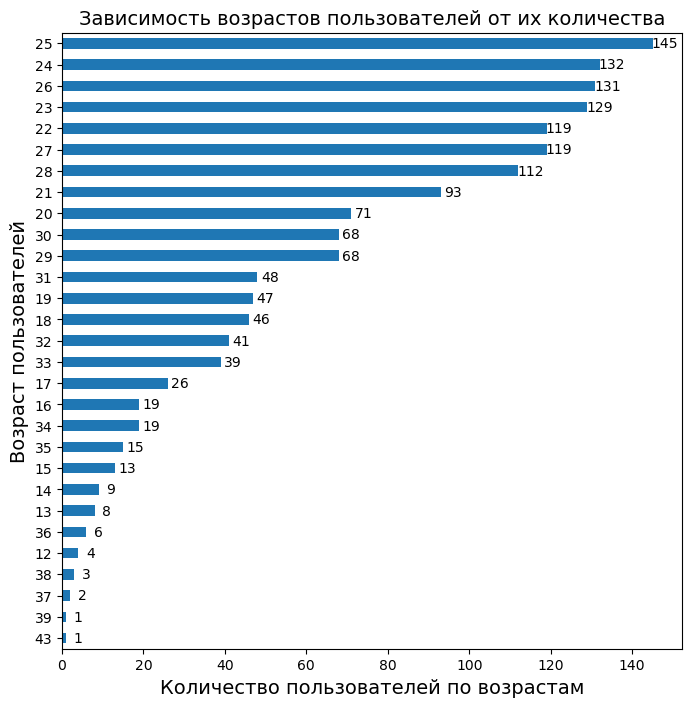

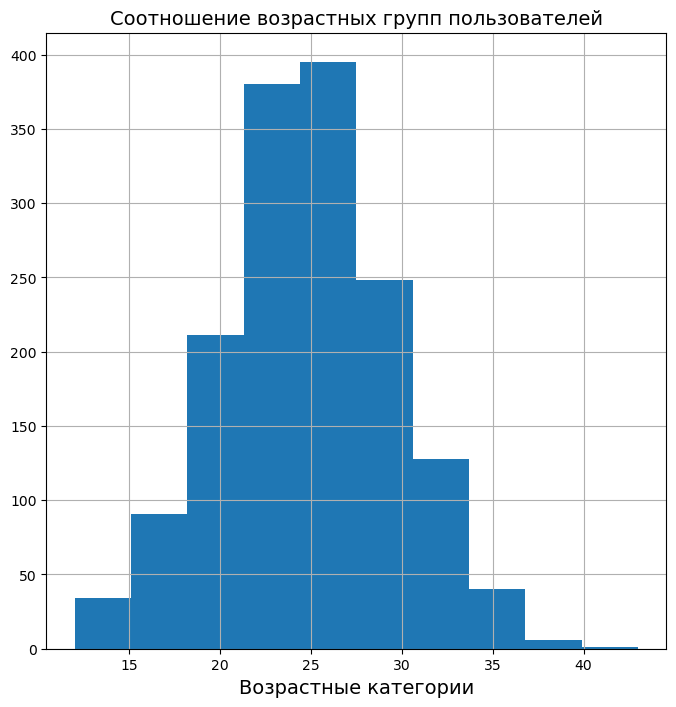

In [28]:
#Построим график показывающий возраст пользователей
users_go['age'].value_counts(ascending=True).plot(kind='barh', figsize=(8, 8))
for i, v in enumerate(users_go['age'].value_counts(ascending=True)):
    plt.text(v+3, i - 0.2, str(round(v, 2)), ha = 'center', size = 10)
plt.title('Зависимость возрастов пользователей от их количества', fontsize=14)
plt.ylabel('Возраст пользователей', fontsize=14)
plt.xlabel('Количество пользователей по возрастам', fontsize=14)
plt.show()
users_go['age'].hist(figsize=(8, 8))
plt.title('Соотношение возрастных групп пользователей', fontsize=14)
plt.xlabel('Возрастные категории', fontsize=14)
plt.show()

Изучив графики и возраст пользователей, можно сделать вывод, что чаще всего приложением пользуются люди в возрасте 25 лет. Меньше всего пользуются приложением люди старше 35 лет и дети недостигшие 18 лет.

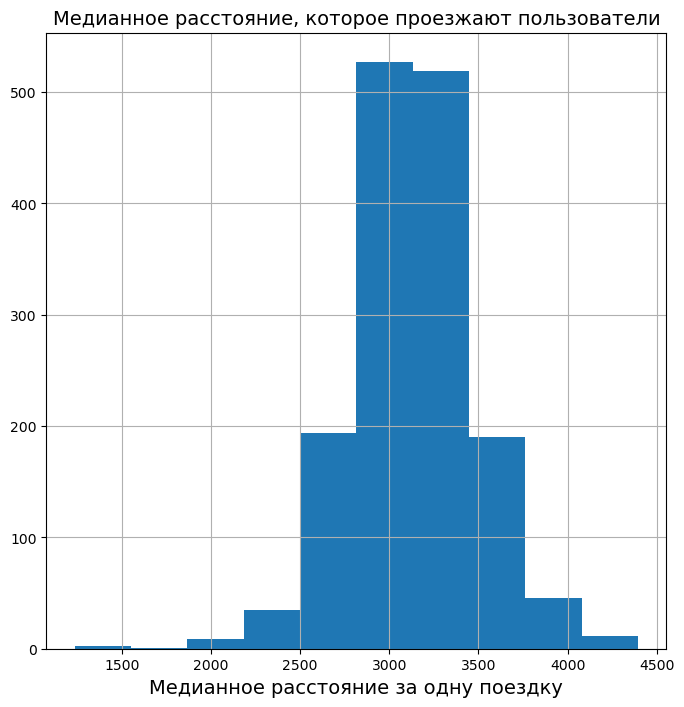

In [29]:
#Объявляю переменную и записываю в нее мкдианное значение дистанции поездки, группирую по user_id
distance_mean_values = rides_go.groupby('user_id')['distance'].median()
distance_mean_values.hist(figsize=(8,8))
plt.title('Медианное расстояние, которое проезжают пользователи', fontsize=14)
plt.xlabel('Медианное расстояние за одну поездку', fontsize=14)
plt.show()

Глядя на график, можно увидеть, что медианная продолжительность поездок у большинства пользователей занимает от 2,5 до 3,7 км.

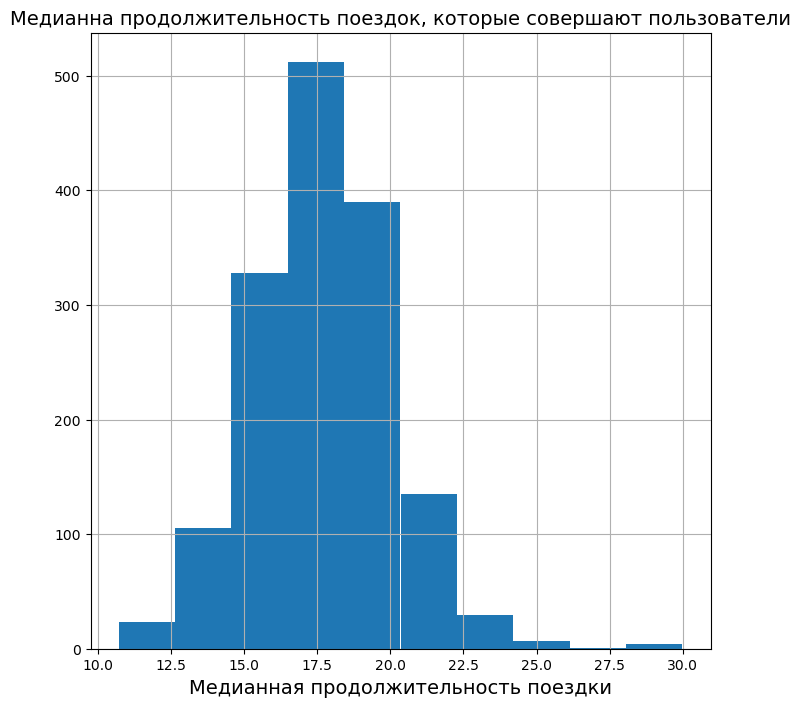

In [30]:
#Объявляю переменную и записываю в нее медианное значение продолжительности поездки, группирую по user_id
duration_mean_values = rides_go.groupby('user_id')['duration'].median()
duration_mean_values.hist(figsize=(8,8))
plt.title('Медианна продолжительность поездок, которые совершают пользователи', fontsize=14)
plt.xlabel('Медианная продолжительность поездки', fontsize=14)

plt.show()

Большинство поездок пользователей длятся в среднем от 14 до 20 минут.

Выведем описание всех столбцов, чтобы посмотреть какие столбцы необходимо проверить на наличие аномальных значений.

In [31]:
rides_go.describe()

,user_id,distance,duration,month
count,18068.000000,18068.000000,18068.000000,18068.000000
mean,842.869936,3070.659976,17.805011,6.486772
std,434.734317,1116.831209,6.091051,3.437410
min,1.000000,0.855683,0.500000,1.000000
25%,487.000000,2543.226360,13.597563,4.000000
50%,889.000000,3133.609994,17.678395,6.000000
75%,1213.250000,3776.222735,21.724800,9.000000
max,1534.000000,7211.007745,40.823963,12.000000


В столбце с расстояением минимальное значение пройденого расстояния меньше метра, аналогиченая ситуация с минимальным значением столбца с затраченным на поездку временем. Проверим данные столбцы на аномальные значения ниже.

Проверим аномальные значения в столбце `duration` - длительности поездки.

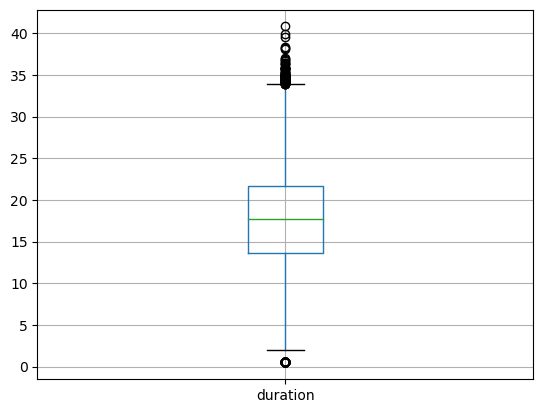

In [32]:
#Объявим функцию для построения отдельных графиков диаграммы размаха
def plot_boxplot(data_frame, column_name):
    data_frame.boxplot(column=[column_name])
    plt.grid(True)
    plt.show()
plot_boxplot(rides_go, 'duration')

Можно заметить, что есть небольшие выбросы равные нулевому значению. Скорее всего поездка не была совершена, но плата за старт поездки была списана, поэтому длительность поездки равная 0 или близкому к нему значению. Удалять такие аномалии не будем.


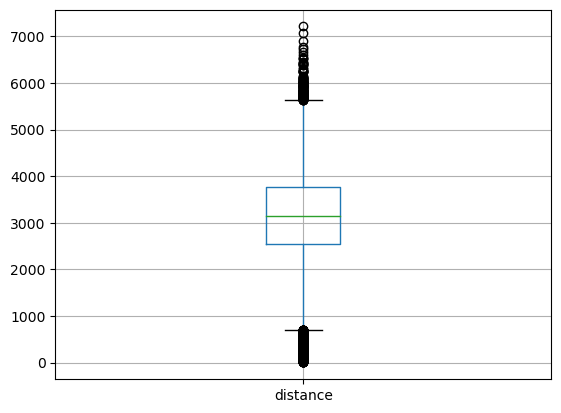

In [33]:
plot_boxplot(rides_go, 'distance')

В столбце с расстоянием, которое преодолевают пользователи во время поездки, тоже есть выбросы с двух сторон. Единичные редкие значения, которые сосредоточены на отметке 7000 метров - максимальное расстояние, которое проехал пользователь. Трудно однозначно сказать, что такое значение является не реалистичным, поэтому удалять его не будем.

Теперь выведем описание столбцов таблицы `users_go`.

In [34]:
users_go.describe()

,user_id,age
count,1534.000000,1534.000000
mean,767.500000,24.903520
std,442.971971,4.572367
min,1.000000,12.000000
25%,384.250000,22.000000
50%,767.500000,25.000000
75%,1150.750000,28.000000
max,1534.000000,43.000000


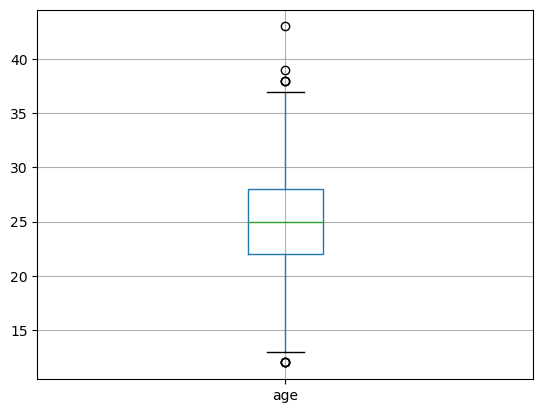

In [35]:
plot_boxplot(users_go, 'age')

В столбце с возрастом пользователей есть единичные выбросы. небольшая группа выбросов находится ниже первой квартили и равна примерно возрасту 12 лет (по приведенной выше таблице с описанием), а также есть выбросы за третьей квартилью в районе 38 лет и больше. Не будем удалять эти выбросы, так как вполне возможно, что пользователи данных возрастных категорий пользуются сервисом проката самоката, просто эти группы не многочислена.

#### Шаг 4. Объединение данных

Произведем объединение данных о пользователях, поездках и типах подписок в одну общую таблицу.


In [36]:
#Присоединим к таблице users_go таблицу rides_go
users_rides_combine_table = users_go.merge(rides_go, how='inner', on='user_id')
users_rides_combine_table.head(20)

,user_id,name,age,city,subscription_type,distance,duration,date,month
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8
5,1,Кира,22,Тюмень,ultra,2770.890808,16.650138,2021-10-09,10
6,1,Кира,22,Тюмень,ultra,3039.020292,14.927879,2021-10-19,10
7,1,Кира,22,Тюмень,ultra,2842.118050,23.117468,2021-11-06,11
8,1,Кира,22,Тюмень,ultra,3412.690668,15.238072,2021-11-14,11
9,1,Кира,22,Тюмень,ultra,748.690645,15.041884,2021-11-22,11


Объединение двух таблиц было произведено по параметру`inner`, то есть по значению ключа из левой таблицы, который в то же время есть и в правой таблице, в нашем случае - это ключ `user_id`. Теперь необходимо к этой таблице присоединить третью таблицу с информацией о типах подписок.

In [37]:
combine_info_table = users_rides_combine_table.merge(subscriptions_go, how='inner', on='subscription_type')
combine_info_table.head(20)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
5,1,Кира,22,Тюмень,ultra,2770.890808,16.650138,2021-10-09,10,6,0,199
6,1,Кира,22,Тюмень,ultra,3039.020292,14.927879,2021-10-19,10,6,0,199
7,1,Кира,22,Тюмень,ultra,2842.118050,23.117468,2021-11-06,11,6,0,199
8,1,Кира,22,Тюмень,ultra,3412.690668,15.238072,2021-11-14,11,6,0,199
9,1,Кира,22,Тюмень,ultra,748.690645,15.041884,2021-11-22,11,6,0,199


Присоединили к предыдущей объединенной таблице таблицу с информацией о типах подписок. Присоединение происходило по общему в двух таблицах ключу - `subscription_type`. 

Финальная объединенная таблица `combine_info_table` теперь содержит в себе информацию о пользователях, поездках и подписках.

Проверим не изменился ли размер таблицы до объединения и после.

In [38]:
print('Размер таблиц до объединения: \nтаблица "users_go"',len(users_go), \
      'строк \nтаблица "rides_go"', len(rides_go), 'строк \nтаблица "subscriptions_go"',\
      len(subscriptions_go), 'строки')

Размер таблиц до объединения: 
таблица "users_go" 1534 строк 
таблица "rides_go" 18068 строк 
таблица "subscriptions_go" 2 строки


In [39]:
print('Размер общей таблицы после объединения равен', len(combine_info_table))

Размер общей таблицы после объединения равен 18068


Количество строк в объединенной таблице равно количеству строк в самой длинной таблице `rides_go`. Проверим, есть ли пропуски в объединенной таблице.

In [40]:
combine_info_table.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
month                0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Пропуски в объединенной таблице отсутствуют. Это говорит о том, что нам удалось объединить данные без потери информации.

Как мы видим, размер таблиц до и после объединения совпадает, и пропуски в данных отсутствуют, следовательно, таблицы объединены верно без потерь данных. 

Создадим две таблицы. В одной будет информация о пользователях с платной подпиской, а в другой - без подписки, соответственно.

In [41]:
users_free_subs_table = combine_info_table.loc[combine_info_table['subscription_type'] == 'free']
users_free_subs_table.head(20)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0
6505,700,Айдар,22,Омск,free,4342.002254,22.368009,2021-02-23,2,8,50,0
6506,700,Айдар,22,Омск,free,3798.334905,18.243756,2021-03-03,3,8,50,0
6507,700,Айдар,22,Омск,free,2984.551206,15.424899,2021-04-09,4,8,50,0
6508,700,Айдар,22,Омск,free,3360.107141,16.765497,2021-06-12,6,8,50,0
6509,700,Айдар,22,Омск,free,2567.543847,11.312160,2021-06-23,6,8,50,0


In [42]:
#Проверка, что в поле с типом подписки, есть только подписка free
users_free_subs_table['subscription_type'].unique()

array(['free'], dtype=object)

In [43]:
len(users_free_subs_table)

11568

Создали таблицу с пользователями у которых нет платной подписки. Таких пользователей оказалось 11568 человек.
Теперь создадим таблицу для пользователей, у которых есть подписка.

In [44]:
users_ultra_subs_table = combine_info_table.loc[combine_info_table['subscription_type'] == 'ultra']
users_ultra_subs_table.head(20)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
5,1,Кира,22,Тюмень,ultra,2770.890808,16.650138,2021-10-09,10,6,0,199
6,1,Кира,22,Тюмень,ultra,3039.020292,14.927879,2021-10-19,10,6,0,199
7,1,Кира,22,Тюмень,ultra,2842.118050,23.117468,2021-11-06,11,6,0,199
8,1,Кира,22,Тюмень,ultra,3412.690668,15.238072,2021-11-14,11,6,0,199
9,1,Кира,22,Тюмень,ultra,748.690645,15.041884,2021-11-22,11,6,0,199


In [45]:
#Проверка, что в поле с типом подписки, есть только подписка ultra
users_ultra_subs_table['subscription_type'].unique()

array(['ultra'], dtype=object)

In [46]:
len(users_ultra_subs_table)

6500

Создали таблицу с информацией о пользователях, у которых есть платная подписка на сервис. Таких пользователей оказалось 6500 человек. 

Проверим, что сумма длин двух новых таблиц равна длине общей таблицы, что никакие строки не потерялись. 

In [47]:
len(combine_info_table)

18068

In [48]:
len(users_free_subs_table) + len(users_ultra_subs_table)

18068

Длина идентичная. Теперь необходимо визуализировать и проанализировать данные о пользователях этих двух категорий. Для этого создадим сводные таблицы.

После создания двух новых таблиц необходимо проверить их на наличие пропусков.


In [49]:
users_free_subs_table.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
month                0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

In [50]:
users_ultra_subs_table.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
month                0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Пропуски в новых таблицах отсутствуют.

In [51]:
#Создаем сводную таблицу для пользователей без платной подписки
users_free_subs_pivot = users_free_subs_table.pivot_table(index='user_id',
                                                          values=['distance', 'duration'], aggfunc='median')
users_free_subs_pivot = users_free_subs_pivot.reset_index()
users_free_subs_pivot.columns = ['ID пользователя', 'Среднее расстояние', 'Средняя продолжительность']
users_free_subs_pivot.head(10)

,ID пользователя,Среднее расстояние,Средняя продолжительность
0,700,3015.965321,15.616269
1,701,3436.950905,15.137141
2,702,3387.284767,19.228790
3,703,2547.626997,10.859179
4,704,3261.700990,17.509964
5,705,3490.443076,17.902229
6,706,2475.365121,16.627218
7,707,2606.329944,17.408277
8,708,3110.405783,17.220812
9,709,2892.828435,17.473408


In [52]:
#Создаем сводную таблицу для пользователей с платной подпиской
users_ultra_subs_pivot = users_ultra_subs_table.pivot_table(index='user_id',
                                                          values=['distance', 'duration'], aggfunc='median')
users_ultra_subs_pivot = users_ultra_subs_pivot.reset_index()
users_ultra_subs_pivot.columns = ['ID пользователя', 'Среднее расстояние', 'Средняя продолжительность']
users_ultra_subs_pivot.head(10)

,ID пользователя,Среднее расстояние,Средняя продолжительность
0,1,2806.504429,16.233505
1,2,3105.086678,18.779128
2,3,2858.693148,19.835873
3,4,3373.276987,20.723324
4,5,3244.021903,14.904990
5,6,3342.862006,19.299796
6,7,3097.667054,15.388281
7,8,2961.450891,16.412482
8,9,2763.948736,16.817230
9,10,3235.302032,17.724327


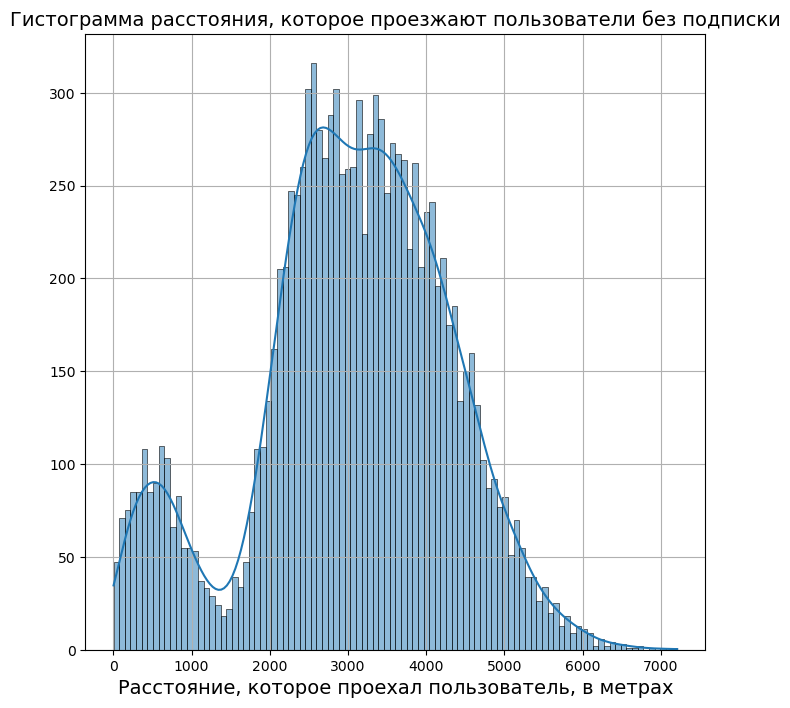

In [53]:
#Построим график с информацией о среднем расстоянии пользователей без подписки
plt.figure(figsize=(8, 8))
sns.histplot(users_free_subs_table['distance'], kde=True, bins=100)
plt.title('Гистограмма расстояния, которое проезжают пользователи без подписки', fontsize=14)
plt.xlabel('Расстояние, которое проехал пользователь, в метрах', fontsize=14)
plt.grid()
plt.ylabel('')
plt.show()

На гистограмме о пройденом пользователями без подписки расстоянии видим распределение с изолированным пиком в районе от 0 до 1000 метров. Скорее всего это и есть те выбросы, которые мы ранее визуализировали на диаграмме размаха таблицы `rides_go`. 

Что касается основного колокола гистограммы, то большинство значений входят в диапазон от 2000 метров до 4500 метров.

Теперь посмотри на гистограмму расстояния пользователей с подпиской.

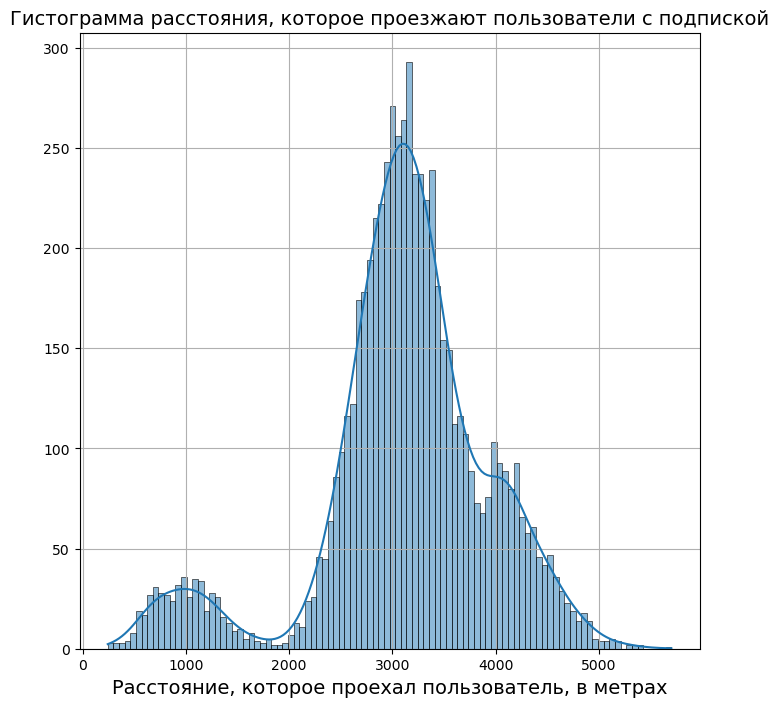

In [54]:
#Построим график с информацией о среднем расстоянии пользователей с подпиской
plt.figure(figsize=(8, 8))
sns.histplot(users_ultra_subs_table['distance'], kde=True, bins=100)
plt.title('Гистограмма расстояния, которое проезжают пользователи с подпиской', fontsize=14)
plt.xlabel('Расстояние, которое проехал пользователь, в метрах', fontsize=14)
plt.grid()
plt.ylabel('')
plt.show()

Похожая ситуация происходит на гистограмме расстояния, пройденного пользователями с подпиской, видим пик на краю в районе 1000 метров. Основные же значения расстояния данной группы находятся в диапазоне от 2500 до 3500 метров.

Сравним результаты двух табдиц и графиков с информацией о расстоянии. 

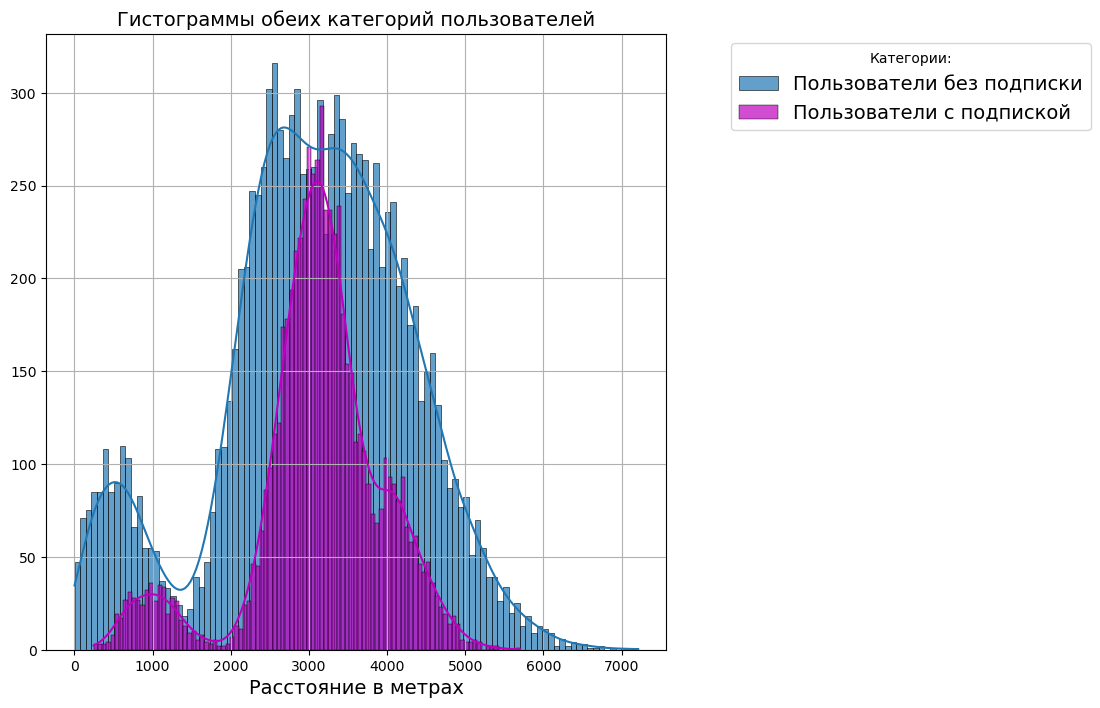

In [55]:
plt.figure(figsize=(8, 8))
sns.histplot(users_free_subs_table['distance'],
             bins=100,
             alpha=0.7,
             kde=True,
             label='Пользователи без подписки')
sns.histplot(users_ultra_subs_table['distance'],
             bins=100,
             alpha=0.7,
             kde=True,
             label='Пользователи с подпиской', color='m')
plt.grid()
plt.xlabel('Расстояние в метрах', fontsize=14)
plt.title('Гистограммы обеих категорий пользователей', fontsize=14)
plt.legend(title='Категории:',
          fontsize=14,
          bbox_to_anchor=(1.7, 0, 0, 1))
plt.ylabel('')
plt.show()

На графиках видим распределения с пиком на краю. Можно заметить, что график пользователей без платной подписки имеет более широкий "колокол" чем график пользователей с платной подпиской, у второй категории "колокол" более пикообразный. Диапазон пройденного расстояния у пользователей без подписки также выше, чем диапазон расстояния у пользователей с подпиской.

Ниже сравним графики продолжительности сессий для двух видов пользователей: с подпиской и без.

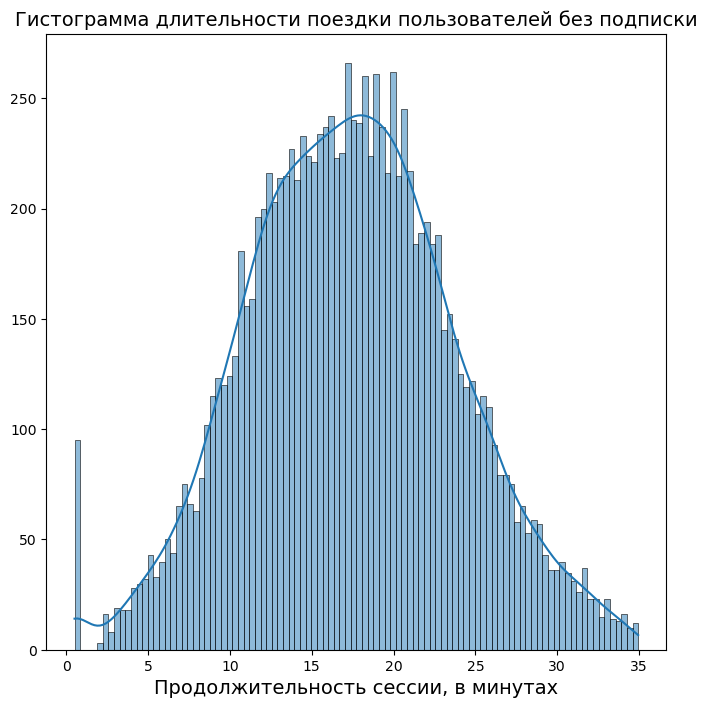

In [56]:
plt.figure(figsize=(8, 8))
sns.histplot(users_free_subs_table['duration'], kde=True, bins=100)
plt.title('Гистограмма длительности поездки пользователей без подписки', fontsize=14)
plt.xlabel('Продолжительность сессии, в минутах', fontsize=14)
plt.ylabel('')
plt.show()

На гистограмме длительности поездки пользователей без подписки видим единичный всплеск в районе нуля. На предыдущем этапе мы находили минимальное значение, равное длительности 0.5 минут, которое также было отображено на диаграмме размаха. Скорее всего этот пик может свидетельствовать о чем-то.

Проверим есть ли такой же пик на гистограмме пользователей с подпиской.

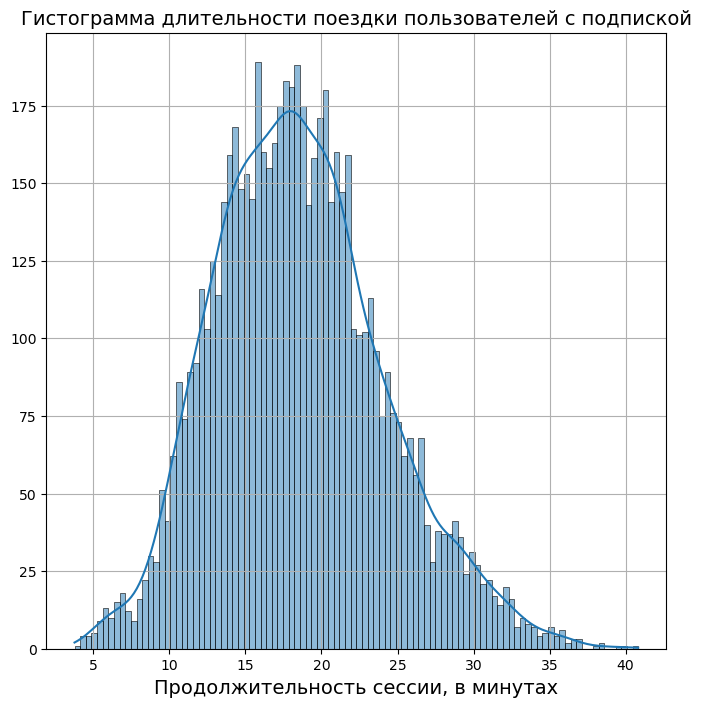

In [57]:
plt.figure(figsize=(8, 8))
sns.histplot(users_ultra_subs_table['duration'], kde=True, bins=100)
plt.title('Гистограмма длительности поездки пользователей с подпиской', fontsize=14)
plt.xlabel('Продолжительность сессии, в минутах', fontsize=14)
plt.grid()
plt.ylabel('')
plt.show()

На графике продлжительности сессии у пользователей с подпиской видим нормальное распределение. В отличие от гистограммы пользователей без подписки здесь отсутствует выброс в районе 0.5. Совместим обе гистограммы для наглядного сравнения.

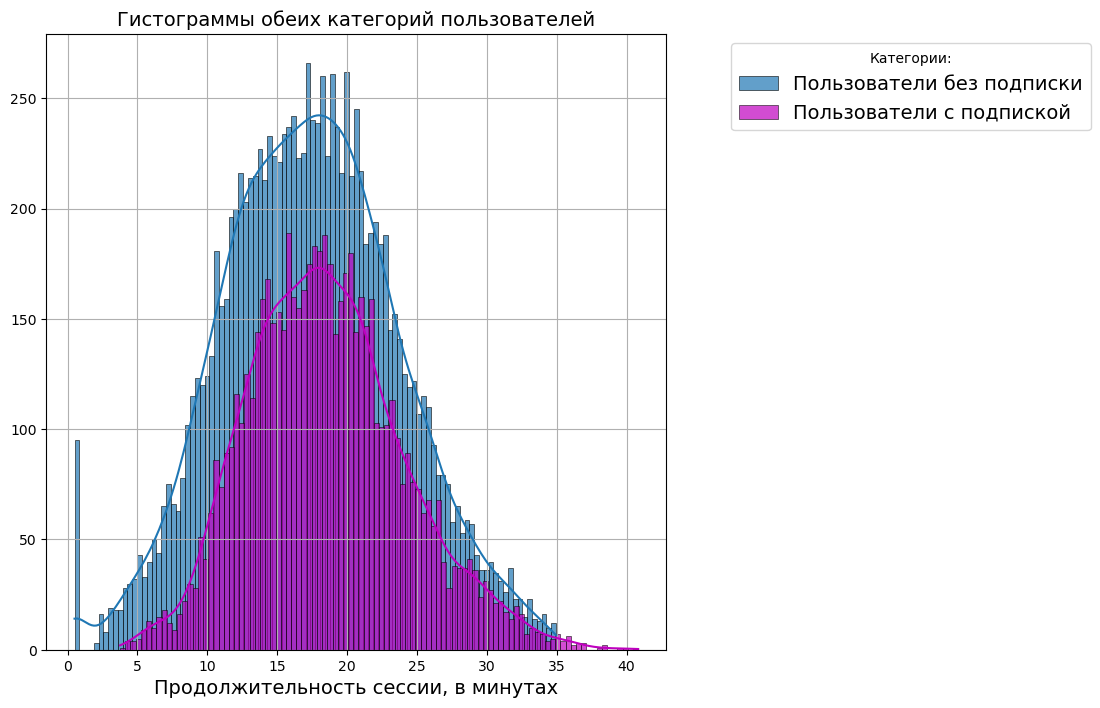

In [58]:
plt.figure(figsize=(8, 8))
sns.histplot(users_free_subs_table['duration'],
             bins=100,
             alpha=0.7,
             kde=True,
             label='Пользователи без подписки')
sns.histplot(users_ultra_subs_table['duration'],
             bins=100,
             alpha=0.7,
             kde=True,
             label='Пользователи с подпиской', color='m')
plt.grid()
plt.xlabel('Продолжительность сессии, в минутах', fontsize=14)
plt.title('Гистограммы обеих категорий пользователей', fontsize=14)
plt.legend(title='Категории:',
          fontsize=14,
          bbox_to_anchor=(1.7, 0, 0, 1))
plt.ylabel('')
plt.show()

In [59]:
users_free_subs_table['duration'].describe()

count    11568.000000
mean        17.390909
std          6.326803
min          0.500000
25%         12.958437
50%         17.326890
75%         21.594071
max         34.948498
Name: duration, dtype: float64

In [60]:
users_ultra_subs_table['duration'].describe()

count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64

На гистограммах продолжительности сессий у пользователей двух категорий видим нормальное распределение. "Колокол" гистограммы пользователей без подписки шире, чем "колокола" гистограммы пользователей с подпиской.
Можно сказать, что пользователи без подписки в среднем проезжают больше расстояния, чем пользователи с подпиской. Длительность их сессий примерно одинаковая.

Также при сравнении двух гистограмм и при вызове метода `describe()` видим, что всплеск в 0.5 минут равен минимальному значению в таблице с пользователями без подписки. Такой всплеск больше походит на закономерность, нежели чем просто единичное аномальное значение. Это может говорить о том, что у пользователей без подписки происходят какие-то сбои, например, сбой работы приложения, после 30 секунд с начала поездки. 

#### Шаг 5. Подсчёт выручки

Необходимо создать датафрейм с агрегированными данными о поездках. Также найти суммарное расстояние, количество поездок и суммарное время для каждого пользователя.

In [61]:
#Округлим значения продолжительности поездки с помощью метода "потолок"
combine_info_table['duration'] = np.ceil(combine_info_table['duration'])
agregate_table = combine_info_table.groupby(['user_id', 'month']).agg({'distance':['sum', 'count'],
                                                                      'duration':'sum',
                                                                      'start_ride_price':'first', 
                                                                      'minute_price':'first',
                                                                      'subscription_fee':'first',
                                                                      'subscription_type':'first'})
agregate_table.columns = agregate_table.columns.map('_'.join).str.strip('_')
agregate_table = agregate_table.reset_index()
agregate_table.head(10)

,user_id,month,distance_sum,distance_count,duration_sum,start_ride_price_first,minute_price_first,subscription_fee_first,subscription_type_first
0,1,1,7027.511294,2,42.0,0,6,199,ultra
1,1,4,754.159807,1,7.0,0,6,199,ultra
2,1,8,6723.470560,2,46.0,0,6,199,ultra
3,1,10,5809.911100,2,32.0,0,6,199,ultra
4,1,11,7003.499363,3,56.0,0,6,199,ultra
5,1,12,6751.629942,2,28.0,0,6,199,ultra
6,2,3,10187.723006,3,63.0,0,6,199,ultra
7,2,4,6164.381824,2,40.0,0,6,199,ultra
8,2,6,3255.338202,1,14.0,0,6,199,ultra
9,2,7,6780.722964,2,48.0,0,6,199,ultra


Проверим агрегированную таблицу на пропуски.


In [62]:
agregate_table.isna().sum()

user_id                    0
month                      0
distance_sum               0
distance_count             0
duration_sum               0
start_ride_price_first     0
minute_price_first         0
subscription_fee_first     0
subscription_type_first    0
dtype: int64

В агрегированной таблице пропуски отсутствуют.

In [63]:
#Добавим в таблицу новый столбец с помесячной выручкой пользователей
agregate_table['month_revenue'] = (agregate_table['start_ride_price_first'] * \
                                   agregate_table['distance_count']) + \
                                   (agregate_table['minute_price_first'] * \
                                   agregate_table['duration_sum']) + \
                                   agregate_table['subscription_fee_first'] 
agregate_table.head()

,user_id,month,distance_sum,distance_count,duration_sum,start_ride_price_first,minute_price_first,subscription_fee_first,subscription_type_first,month_revenue
0,1,1,7027.511294,2,42.0,0,6,199,ultra,451.0
1,1,4,754.159807,1,7.0,0,6,199,ultra,241.0
2,1,8,6723.470560,2,46.0,0,6,199,ultra,475.0
3,1,10,5809.911100,2,32.0,0,6,199,ultra,391.0
4,1,11,7003.499363,3,56.0,0,6,199,ultra,535.0


In [64]:
agregate_table['month_revenue'].sum()

3878641.0

#### Шаг 6. Проверка гипотез

Теперь необходимо будет проверить несколько гипотез. 

**6.1 Первая гипотеза** говорит о том, что пользователи с подпиской тратят больше времени на поездку, чем пользователи без подписки.


Нулевая гипотеза в данном случае будет звучать так: "Средние значения трат времени пользователей с подпиской и без подписки равны". 

Альтернативная гипотеза: "Среднее значение трат времени группы с подпиской больше, чем среднее значение трат пользователей без подписки".

Для проверки будет использоваться метод `scipy.stats.ttest_ind()` для проверки гипотез о равенстве среднего двух генеральных совокупностей по взятым из них выборкам.

In [65]:
#Указываем уровень значимости
alpha = 0.05
result = st.ttest_ind(users_ultra_subs_table['duration'], users_free_subs_table['duration'], alternative='greater')
print('значение p-value:', result.pvalue)

#Проверяем p-value
if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу в пользу альтернативной.')
else:
    print('Нет оснований отвергнуть нулевую гипотезу.')

значение p-value: 1.2804098316645618e-34
Отвергаем нулевую гипотезу в пользу альтернативной.


Так как p-value очень маленький, это означает очень маленькую вероятность того, что наблюдаемые пространственные закономерности - это результат случайных процессов, поэтомуму нулевая гипотеза о равенстве была отвергнута в пользу альтернативной, это значит, что среднее значение трат времени группы с подпиской больше, чем среднее значение трат пользователей без подписки.

Так как пользователи имеющие подписку тратят больше времени, чем пользователи без подписки, то с точки зрения бизнеса гораздо более выгодно, чтобы как можно больше пользователей имело подписку на сервис. Но на текущий момент пользователей без подписки значительно больше, поэтому для увеличения прибыли необходимо простимулировать текущих пользователей без подписки на то, чтобы им также было выгоднее использовать подписку.

**6.2 Вторая гипотеза**, которую необходимо проверить, заключается в следующем: расстояние одной поездки в 3130 метров - оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?

Сформулируем нулевую гипотезу: "Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку не превышает 3130 метров"

Альтернативная гипотеза: "Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку превышает 3130 метров". Это значит, что данная гипотеза будет односторонней, необходимо найти правый "хвост", который покажет расстояние, превышающее значение 3130 и приводит к повышенному износу самоката. 

Для проверки будет использоваться метод `scipy.stats.ttest_1samp()` о равенстве среднего генеральной совокупности некоторому значению.

In [66]:
#Указываем число, с которым сравниваем
compared_value = 3130
#Указываем уровень значимости
alpha = 0.05
result_two = st.ttest_1samp(users_ultra_subs_table['distance'], compared_value, alternative='greater')
print('значение p-value:', result_two.pvalue)
#Проверяем p-value
if result_two.pvalue < alpha:
    print('Отвергаем нулевую гипотезу в пользу альтернативной.')
else:
    print('Нет оснований отвергнуть нулевую гипотезу.')

значение p-value: 0.9195368847849785
Нет оснований отвергнуть нулевую гипотезу.


В данном случае p-value получилось больше цровня значимости, следовательно, отвергнуть нулевую гипотезу мы не можем. Значит , среднее расстояние, котрое проезжают пользователи с подпиской, не превышает значение 3130 метров и не приводит к повышенному износу самоката.

С точки зрения бизнеса текущее расстояние, которое преодолевают пользователи на самокатах, является выгодным так как не способствует повышенному износу самокатов.


**6.3 Третья гипотеза** заключается в том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?

Нулевая гипотеза: "Помесячная выручка от пользователей с подпиской по месяцам равна помесячной выручке от пользователей без подписки по месяцам".

Альтернативная гипотеза: "Помесячная выручка от пользователей с подпиской больше, чем помесячная выручка от пользователей без подписки.

Перед тем как начать проверять гипотезу, необходимо немного доработать таблицу с информацией о выручке, которую приносят пользователи. А далее использовать метод `scipy.stats.ttest_ind()`.

In [67]:
agregate_table_ultra = agregate_table.loc[agregate_table['subscription_type_first'] == 'ultra']
agregate_table_free = agregate_table.loc[agregate_table['subscription_type_first'] == 'free']

In [68]:
#Указываем уровень значимости
alpha = 0.05
result_tree = st.ttest_ind(agregate_table_ultra['month_revenue'],
                           agregate_table_free['month_revenue'],
                           alternative='greater')
print('значение p-value:', result_tree.pvalue)

#Проверяем p-value
if result_tree.pvalue < alpha:
    print('Отвергаем нулевую гипотезу в пользу альтернативной.')
else:
    print('Нет оснований отвергнуть нулевую гипотезу.')

значение p-value: 1.8850394384715216e-31
Отвергаем нулевую гипотезу в пользу альтернативной.


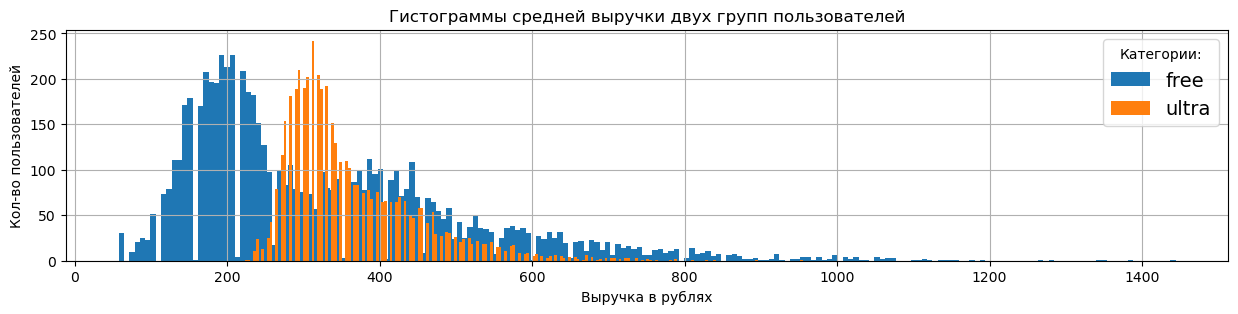

In [69]:
agregate_table.groupby('subscription_type_first')['month_revenue'].hist(bins=200, figsize=(15,3), legend=True)
plt.title('Гистограммы средней выручки двух групп пользователей')
plt.xlabel('Выручка в рублях')
plt.ylabel('Кол-во пользователей')
plt.legend(title='Категории:',
          fontsize=14)
plt.show()

Нулевая гипотеза была отвергнута в пользу альтернативной, значит помесячная выручка от пользователей с подпиской больше, чем выручка от пользователей без подписки.

Так как выручка от пользователей с подпиской больше, чем от пользователей без подписки, то выгоднее, чтобы как можно большее количество пользователей имело подписку на сервис.


#### Шаг 7. Распределения

**7.1**

Необходимо провести акцию по раздаче промокодов на 1 бесплатный месяц подписки, чтобы как минимум 100 клиентов продлили подписку. Какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5%, если ранее при проведении этой акции 10% пользователей продлевали подписку?

Используем биномиальное распределение. С помощью метода `cdf()` кумулятивной функции распределения, найдем вероятность того, что случайная величина примет значение больше 100. Так как по умолчанию функция даст на выход вероятность, что величина меньше заданного аргумента, необходимо от 1 отнять это значение.

Минимальное количество промокодов, которое необходимо разослать равно 1180  и при них вероятность успеха равна 95.77 %


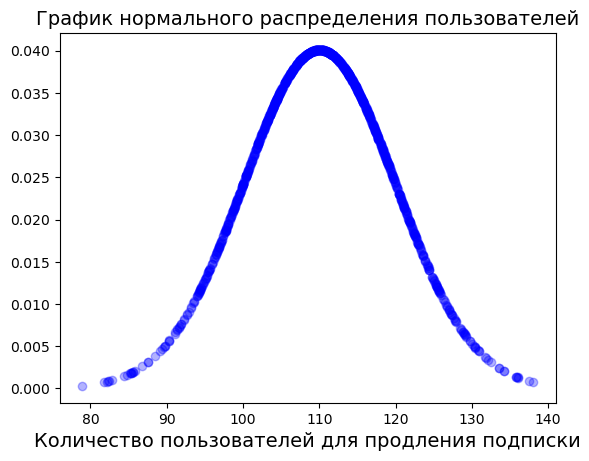

In [70]:
#Зададим параметры распределения
n = 1100
p = 0.1
#Вычислим мат. ожидание
mu = n * p
#Вычислим стандартное отклонение
sigma = sqrt(n * p * (1 - p))
#Задаем нормальное распределение
distr = st.norm(mu, sigma)
#Считаем вероятность хвоста справа от 100
result = 1 - distr.cdf(100)
# print('Вероятность что как минимум 100 клиентов продлят подписку равна', round(result*100, 3),'%')

print('Минимальное количество промокодов, которое необходимо разослать \
равно 1180  и при них вероятность успеха равна', \
      round((1 - binom.cdf(k=100, n=1180 , p=0.1))*100, 2),'%')
a = np.random.normal(mu, sigma, 1100)
ax = plt.subplot()
ax.plot(a, norm.pdf(a, mu, sigma), 'bo', lw=5, alpha=0.3)
plt.title('График нормального распределения пользователей', fontsize=14)
plt.xlabel('Количество пользователей для продления подписки', fontsize=14)
plt.show()

 Количество промокодов, которые необходимо разослать равно 1180 штук при этом вероятность того что 100 пользователей продлят подписку равно 95.77%.

**7.2**

Отдел маркетинга рассылает клиентам push-уведомления. Клиенты могут его открыть или не открыть. Уведомления открывают 40% получивших клиентов. Необходимо найти вероятность того, что уведомления откроют не более 399,5 тысяч пользователей.

Вероятность что уведомления откроют менее 399,5 тысяч пользователей равно 15.372 %


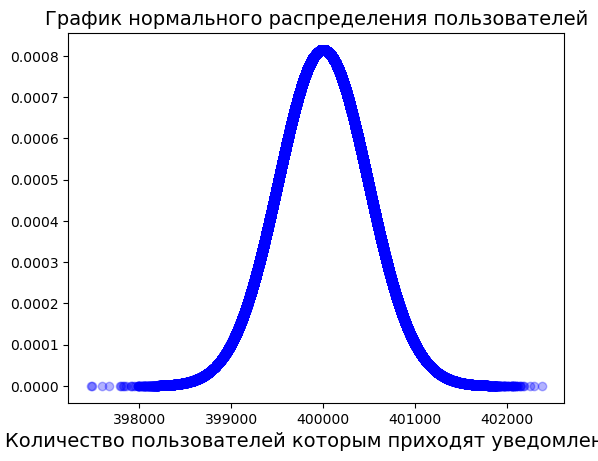

In [71]:
#Задаем параметры распределения
n = 1000000
p = 0.4
#Задаем мат. ожидание и стандартное отклонение
mu = n * p
sigma = sqrt(n * p * (1 - p))
#Задаем нормальное распределение
distr = st.norm(mu, sigma)
#Считаем вероятность хвоста слева от 399500, так как сказано не более этого значения
result = distr.cdf(399500)
print('Вероятность что уведомления откроют менее 399,5 тысяч пользователей равно', round(result*100, 3), '%')
a = np.random.normal(mu, sigma, 1000000)
ax = plt.subplot()
ax.plot(a, norm.pdf(a, mu, sigma), 'bo', lw=5, alpha=0.3)
plt.title('График нормального распределения пользователей', fontsize=14)
plt.xlabel('Количество пользователей которым приходят уведомления', fontsize=14)
plt.show()

Вероятность того, что не больее 399,5 тыс. пользователей откроют уведомления равно 15,372%. Также глядя на график можно увидеть, что большая часть значений находится справа от 399 тысяч. 

#### Общий вывод

В данном проекте был проведен исследовательский анализ, который помог выяснить: какие категории пользователей являются более прибыльными, какие проводят в приложении больше времени.

Сначала были выгружены необходимые для анализа таблицы. На этапе предобработки данных были проверены и заменены на соответствующие типы данных столбцов датафреймов, была проведена проверка на наличие нулевых элементов, явных и неявных дубликатов, был добавлен новый столбец с номером месяца, в котором пользователь совершал поездку, также было выяснено, что в таблице представлены данные для исследования за 2021 год.

Во время исследовательского анализа было вяснино в процентом соотношении какие города являются наиболее популярными у пользователей, а какие наимее популярные. Больше всего людей используют данное приложение из Пятигорска, в то время как меньше всего - из Москвы. Пользователей, пользующихся приложением в Москве на 30% меньше чем в Пятигорске. 

Также было выяснено, что пользователей без подписки на сервис больше на 19%, чем пользователей имеющих ежемесячную подписку Ultra. 

Самые многочисленные категории пользователей сервисом - это люди в возрасте 25 лет, самые малочисленные категории пользователей - несовершеннолетние и люди старше 40 лет.

Были создана объединенная таблица с данными из всех трех исходных таблиц. На основе этой таблицы были созданы две таблицы по категориям пользователей с ежемесячной подпиской и без подписки. На основе таблиц по категориям были созданы сводные таблицы хранящие информацию о id пользователей, время, которое они тратят в приложении и расстояние, которое они проезжают.

По каждой из этих категорий были построены гистограммы, показывающие какое расстояние в среднем проезжают пользователи с подпиской и без подписки. Также построены гистограммы, показывающие сколько в среднем времени тратят пользователи с подпиской и без.Во время исследования были найдены аномальные выбросы у пользователей без подписки. У многих полдьзователей без подписки заканчивалась поездка спустя 30 секунд после старта поездки. Этот всплеск хорошо видно на гистограмме о продолжительности сессий пользователей без подписки из пункта 4 - объединение данных. Это может свидетельствовать о каком-то сбое.

Также был произведен подсчет общей выручки за 2021 год включающий в себя обе категории пользователей. Годовая выручка составила 3.878.641 рублей. 

Были выдвинуты несколько гипотез, во время проверки которых выяснилось, что пользователи, имеющие ежемесячную подписку, тратят больше времени в приложении, чем пользователи без подписки. Также пользователи с подпиской приносят прибыли больше, чем пользователи без подписки. Также было выяснено, что среднее расстояние, которое преодолевают пользователи с подпиской не превышают значения 3130 и не способствуют повышенному износу самоката. 

В следствие чего можно сделать вывод, что намного выгоднее увеличивать количество пользователей, имеющих подписку. Необходимо стимулировать пользователей сервиса, которые еще не имеют подписку,на то, чтобы им было выгоднее использовать ежемесячную подписку на сервис. 